The goal of this notebook is to demonstrate increased probability of finding ground states using the a new cyclic method.  This cycle is just in \alpha .  It trotterizes up and down the vertical axis of the parameter space shown in the Cyclic Quantum Annealing paper.  It treats the stuck QAOA circuit of gamma and beta as an effective Hamiltonian.  

The Problem: In this notebook we will consider an N=18 Ising Model on a complete bipartite graph $K_{9,9}$ with constant edge weights and random local fields.  We anticipate that this Hamiltonian may pose an issue for low p QAOA as a high degree of entanglement is required to account for the local field variations to minimize the frustration in the ground state.  We begin by implementing the problem and then demonstrating its failure at $p=1$.  

In [1]:
import cirq
import networkx as nx
import numpy as np
import qsimcirq
from cqaoa.ising import *
from cqaoa.ansatz import *
from cqaoa.training import *
from cqaoa.brute_force import *

In [2]:
n = 18
lr = n // 2
p = 1
qs = cirq.LineQubit.range(n)
qubit_graph = nx.Graph()
lefts = [i for i in range(lr)]
rights = [i for i in range(lr,n)]
for left in lefts:
    for right in rights:
        qubit_graph.add_edge(qs[left], qs[right], weight=1.0)
rng_inst = np.random.default_rng(9090)
h = rng_inst.normal(0., 0.35, size=n)
for i in range(n):
    qubit_graph.add_edge(qs[i],qs[i],weight = h[i])

hamiltonian = ising_hamiltonian(qubit_graph, weighted=True)

In [3]:
brute_force(qubit_graph,hamiltonian)

(-81.82330279983525,
 array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8))

In [5]:
ansatz = CylicQAOAAnsatz(qubit_graph, hamiltonian, weighted=True)

no_reference_energy, gamma, beta, best_sampled = optimize_ansatz_random_start(ansatz, p, 10)
print(no_reference_energy)
print(gamma)
print(beta)
print(best_sampled)

-49.05499774193554
[0.10765322]
[0.74854429]
-81.82330279983523


I suspect here that the optimization method is causing me issues.  The Powell method as implemented considers the exact energy expectation value.  Perhaps it may weaken our claim to relax this, but this is not very realistic and we may find near optimums by considering sampled energies for the optimizer.  Let's see what the results for this give: 

In [6]:
ansatz = CylicQAOAAnsatz(qubit_graph, hamiltonian, weighted=True)

no_reference_energy, gamma, beta, best_E, prob, best_string = optimize_ansatz_random_start_sampled(ansatz, p, 10)
print(no_reference_energy)
print(gamma)
print(beta)
print(best_E)
print(best_string)
print(prob)

-45.36374277079178
[0.07507615]
[1.7938224]
-81.82330279983523
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
0.00030855496956764053


In [7]:
ansatz = CylicQAOAAnsatz(qubit_graph, hamiltonian, weighted=True)

no_reference_energy, gamma, beta, best_E, prob, best_string = optimize_ansatz_random_start_sampled(ansatz, p, 10)
print(no_reference_energy)
print(gamma)
print(beta)
print(best_E)
print(best_string)
print(prob)

-45.312528196179514
[0.09211621]
[1.80128052]
-81.82330279983523
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
0.00035634434935928605


Okay, so pretty definitively, we see that the ground state probability is quite small (1/5k) while the energy converged quite close.  So indeed, sampling plays a huge role here.  Presumably, it's because this either causes the gamma, beta landscape to be more rough or it reduces the resolution in gamma beta.  We found a quite different optimum, so it's hard to say for certain.  But it's a decent energy.  I will have to check this against our landscape visualizations.  In the meantime,  I wish to implement the cyclic method.  Some preliminary tests suggested that just cycling alpha while keeping the optimized QAOA Hamiltonian on would increase our groundstate probability.  Let's test it.  

In [10]:
def build_vertical_cyclic(qubit_graph, hamiltonian, gamma, beta, alpha, p_cycles, reference, leg_steps=36):
    from cqaoa.ansatz import gamma_layer, beta_layer
    
    circuit = cirq.Circuit()
    for q in qubit_graph.nodes:
        circuit.append(cirq.H(q))
    
    weighted = nx.is_weighted(qubit_graph)
    qs = list(qubit_graph.nodes())
    sref = 1 - 2 * np.array(reference)
    
    def base_half():
        c = cirq.Circuit()
        c += gamma_layer(gamma/2, qubit_graph, weighted)
        c += beta_layer(beta/2, qubit_graph)
        return c
    
    def kick(theta):
        return [cirq.ZPowGate(exponent=-(theta/np.pi)*float(sref[i])).on(qs[i]) for i in range(len(qs))]
    
    d_alpha = alpha / leg_steps
    
    for _ in range(p_cycles):
        for _ in range(leg_steps):
            circuit += base_half()
            circuit.append(kick(d_alpha))
            circuit += base_half()
        
        for _ in range(leg_steps):
            circuit += base_half()
            circuit.append(kick(-d_alpha))
            circuit += base_half()
    
    return circuit


def evaluate_vertical_cyclic(qubit_graph, hamiltonian, gamma, beta, alpha, p_cycles, reference, leg_steps=36):
    circuit = build_vertical_cyclic(qubit_graph, hamiltonian, gamma, beta, alpha, p_cycles, reference, leg_steps)
    sim = cirq.Simulator(dtype=np.complex128)
    state = sim.simulate(circuit).final_state_vector
    
    expectation = sim.simulate_expectation_values(circuit, [hamiltonian])[0].real
    
    from cqaoa.brute_force import brute_force
    ground_energy, ground_string = brute_force(qubit_graph, hamiltonian)
    ground_idx = int(''.join(str(b) for b in ground_string), 2)
    ground_prob = float(np.abs(state[ground_idx])**2)
    
    return expectation, ground_prob


reference = best_string
alpha = 0.1
p_cycles = 1
expectation, ground_prob = evaluate_vertical_cyclic(qubit_graph, hamiltonian, gamma, beta, alpha, p_cycles, reference)

In [11]:
print(expectation)
print(ground_prob)

-47.57584364764185
0.00030536956213741496


I wish to isolate to a state with a little lower ground state probability.  While this is further weakening, the goal is to demonstrate a resonance effect in alpha with the ground state.

In [12]:
ansatz = CylicQAOAAnsatz(qubit_graph, hamiltonian, weighted=True)

no_reference_energy, gamma, beta, best_E, prob, best_string = optimize_ansatz_random_start_sampled(ansatz, p, 2) #2 random restarts only.
print(no_reference_energy)
print(gamma)
print(beta)
print(best_E)
print(best_string)
print(prob)

-45.09272698826306
[0.9078266]
[1.79489536]
-74.05337349310952
[0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1]
0.00027535509233861735


Testing alpha = 0.000
Testing alpha = 0.133
Testing alpha = 0.267
Testing alpha = 0.400
Testing alpha = 0.533
Testing alpha = 0.667
Testing alpha = 0.800
Testing alpha = 0.933
Testing alpha = 1.067
Testing alpha = 1.200


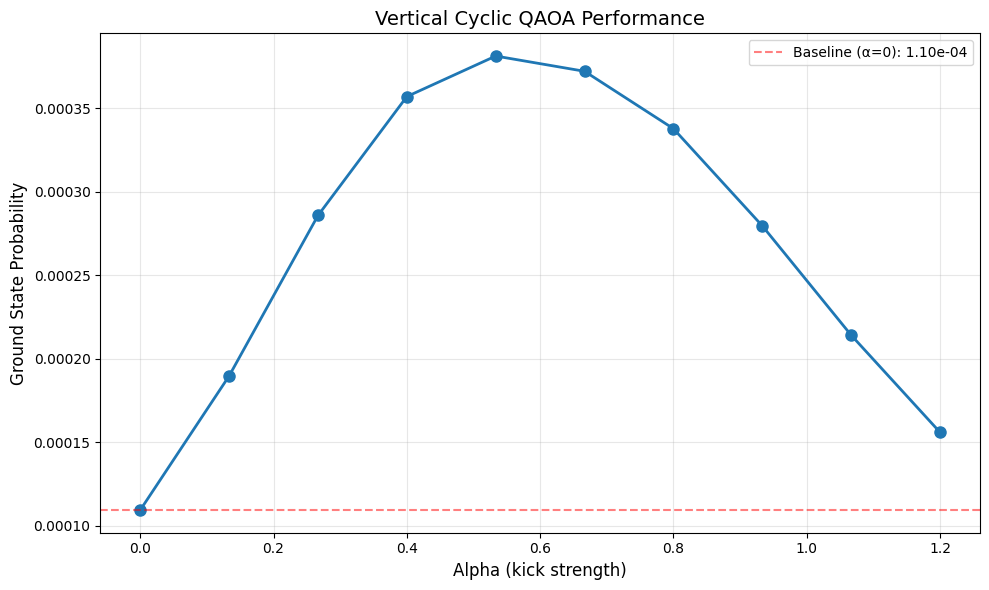


Improvement factors:
α = 0.000: 1.095e-04 (1.00x)
α = 0.133: 1.897e-04 (1.73x)
α = 0.267: 2.857e-04 (2.61x)
α = 0.400: 3.569e-04 (3.26x)
α = 0.533: 3.811e-04 (3.48x)
α = 0.667: 3.720e-04 (3.40x)
α = 0.800: 3.377e-04 (3.08x)
α = 0.933: 2.795e-04 (2.55x)
α = 1.067: 2.141e-04 (1.96x)
α = 1.200: 1.560e-04 (1.42x)


In [15]:
import matplotlib.pyplot as plt
alphas = np.linspace(0.0, 1.2, 10)
ground_probs = []
expectations = []

for alpha in alphas:
    print(f"Testing alpha = {alpha:.3f}")
    expectation, ground_prob = evaluate_vertical_cyclic(
        qubit_graph, hamiltonian, gamma, beta, alpha, 
        p_cycles=1, reference=best_string, leg_steps=36
    )
    ground_probs.append(ground_prob)
    expectations.append(expectation)

baseline_prob = ground_probs[0]

plt.figure(figsize=(10, 6))
plt.plot(alphas, ground_probs, 'o-', linewidth=2, markersize=8)
plt.axhline(y=baseline_prob, color='r', linestyle='--', alpha=0.5, label=f'Baseline (α=0): {baseline_prob:.2e}')
plt.xlabel('Alpha (kick strength)', fontsize=12)
plt.ylabel('Ground State Probability', fontsize=12)
plt.title('Vertical Cyclic QAOA Performance', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\nImprovement factors:")
for alpha, prob in zip(alphas, ground_probs):
    improvement = prob / baseline_prob if baseline_prob > 0 else 0
    print(f"α = {alpha:.3f}: {prob:.3e} ({improvement:.2f}x)")


Testing alpha = 0.000
Testing alpha = 0.133
Testing alpha = 0.267
Testing alpha = 0.400
Testing alpha = 0.533
Testing alpha = 0.667
Testing alpha = 0.800
Testing alpha = 0.933
Testing alpha = 1.067
Testing alpha = 1.200


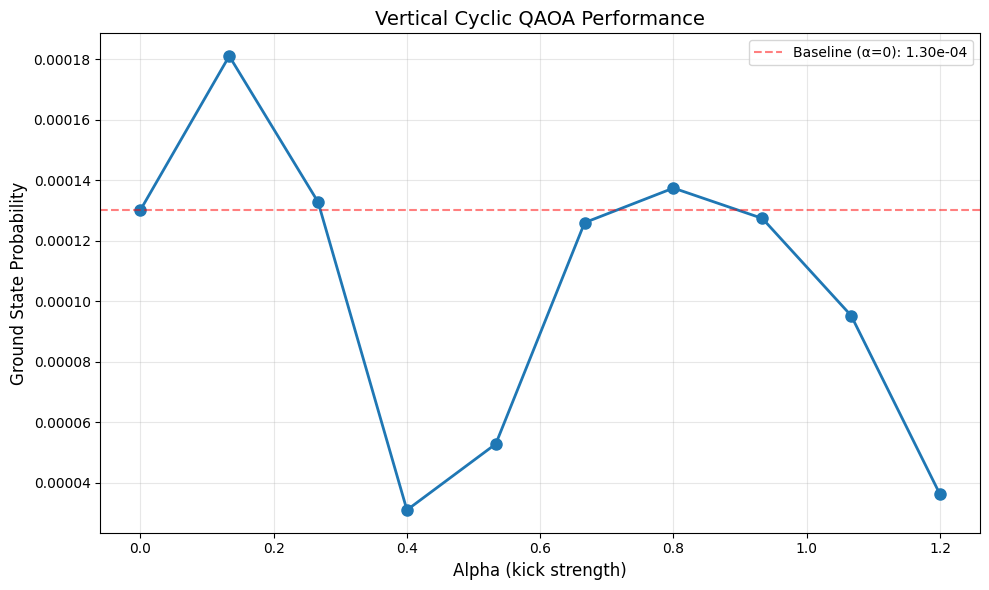


Improvement factors:
α = 0.000: 1.301e-04 (1.00x)
α = 0.133: 1.811e-04 (1.39x)
α = 0.267: 1.328e-04 (1.02x)
α = 0.400: 3.090e-05 (0.24x)
α = 0.533: 5.275e-05 (0.41x)
α = 0.667: 1.260e-04 (0.97x)
α = 0.800: 1.374e-04 (1.06x)
α = 0.933: 1.274e-04 (0.98x)
α = 1.067: 9.520e-05 (0.73x)
α = 1.200: 3.608e-05 (0.28x)


In [16]:
alphas = np.linspace(0.0, 1.2, 10)
ground_probs = []
expectations = []

for alpha in alphas:
    print(f"Testing alpha = {alpha:.3f}")
    expectation, ground_prob = evaluate_vertical_cyclic(
        qubit_graph, hamiltonian, gamma, beta, alpha, 
        p_cycles=2, reference=best_string, leg_steps=36
    )
    ground_probs.append(ground_prob)
    expectations.append(expectation)

baseline_prob = ground_probs[0]

plt.figure(figsize=(10, 6))
plt.plot(alphas, ground_probs, 'o-', linewidth=2, markersize=8)
plt.axhline(y=baseline_prob, color='r', linestyle='--', alpha=0.5, label=f'Baseline (α=0): {baseline_prob:.2e}')
plt.xlabel('Alpha (kick strength)', fontsize=12)
plt.ylabel('Ground State Probability', fontsize=12)
plt.title('Vertical Cyclic QAOA Performance', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\nImprovement factors:")
for alpha, prob in zip(alphas, ground_probs):
    improvement = prob / baseline_prob if baseline_prob > 0 else 0
    print(f"α = {alpha:.3f}: {prob:.3e} ({improvement:.2f}x)")

Testing alpha = 0.000
Testing alpha = 0.133
Testing alpha = 0.267
Testing alpha = 0.400
Testing alpha = 0.533
Testing alpha = 0.667
Testing alpha = 0.800
Testing alpha = 0.933
Testing alpha = 1.067
Testing alpha = 1.200


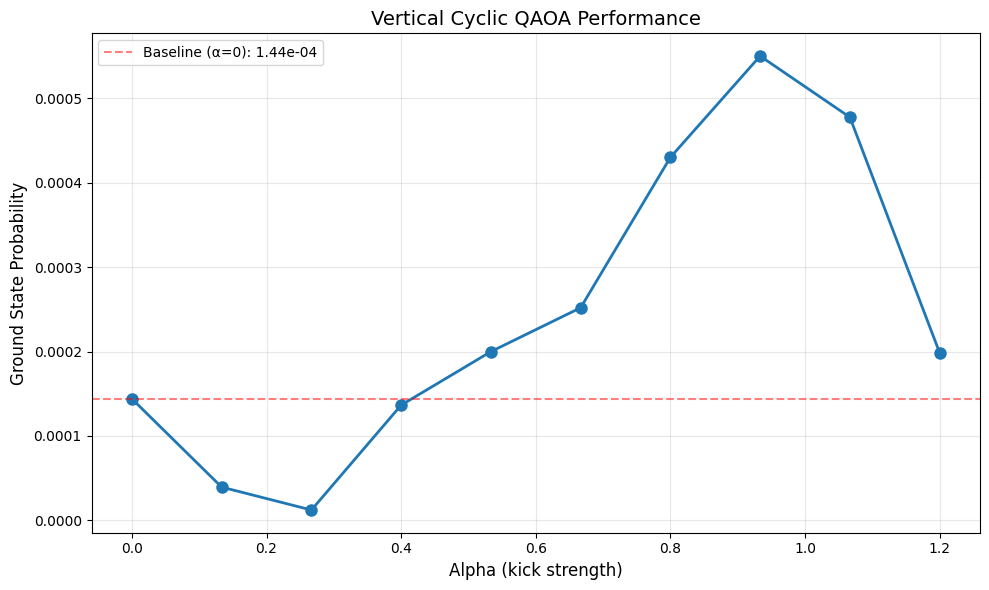


Improvement factors:
α = 0.000: 1.439e-04 (1.00x)
α = 0.133: 3.929e-05 (0.27x)
α = 0.267: 1.212e-05 (0.08x)
α = 0.400: 1.365e-04 (0.95x)
α = 0.533: 1.999e-04 (1.39x)
α = 0.667: 2.519e-04 (1.75x)
α = 0.800: 4.301e-04 (2.99x)
α = 0.933: 5.503e-04 (3.82x)
α = 1.067: 4.777e-04 (3.32x)
α = 1.200: 1.986e-04 (1.38x)


In [18]:
alphas = np.linspace(0.0, 1.2, 10)
ground_probs = []
expectations = []

for alpha in alphas:
    print(f"Testing alpha = {alpha:.3f}")
    expectation, ground_prob = evaluate_vertical_cyclic(
        qubit_graph, hamiltonian, gamma, beta, alpha, 
        p_cycles=3, reference=best_string, leg_steps=36
    )
    ground_probs.append(ground_prob)
    expectations.append(expectation)

baseline_prob = ground_probs[0]

plt.figure(figsize=(10, 6))
plt.plot(alphas, ground_probs, 'o-', linewidth=2, markersize=8)
plt.axhline(y=baseline_prob, color='r', linestyle='--', alpha=0.5, label=f'Baseline (α=0): {baseline_prob:.2e}')
plt.xlabel('Alpha (kick strength)', fontsize=12)
plt.ylabel('Ground State Probability', fontsize=12)
plt.title('Vertical Cyclic QAOA Performance', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\nImprovement factors:")
for alpha, prob in zip(alphas, ground_probs):
    improvement = prob / baseline_prob if baseline_prob > 0 else 0
    print(f"α = {alpha:.3f}: {prob:.3e} ({improvement:.2f}x)")